# 作业：神经网络的“学习学”

In [1]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

%matplotlib inline

## 一、加载数据

### 定义一个dataset按标签范围的读取器

In [2]:
# 设置图像读取器的超参数
image_size = 28  #图像的总尺寸28*28
batch_size = 64  #批处理的尺寸大小

# 如果系统中存在着GPU，我们将用GPU来完成张量的计算
use_cuda = torch.cuda.is_available() #定义一个布尔型变量，标志当前的GPU是否可用

# 如果当前GPU可用，则将优先在GPU上进行张量计算
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载

#定义一个数据输入函数，min为最小值，max为最大值
def dataset(min,max):
    train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

     # 加载测试数据集
    test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

    tr=((train_dataset.targets <=max)&(train_dataset.targets >=min)).nonzero().squeeze()
    train_dataset.targets=train_dataset.targets[tr]
    train_dataset.data=train_dataset.data[tr]
    
    te=((test_dataset.targets <=max)&(test_dataset.targets >=min)).nonzero().squeeze()
    test_dataset.targets=test_dataset.targets[te]
    test_dataset.data=test_dataset.data[te]
    #print(train_dataset)
    #print(test_dataset)
    
    
    # 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

     

     # 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
     # 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
    lens=len(test_dataset)
    indices = range(lens)
    indices_val = indices[:int(lens/2)]
    indices_test = indices[int(lens/2):]

    # 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
    sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
    sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

    # 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
    validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )
    
    
    
    return(train_loader,validation_loader,test_loader)


## 构建卷积网路

In [3]:
# 定义待迁移的网络框架，所有的神经网络模块包括：Conv2d、MaxPool2d，Linear等模块都不需要重新定义，会自动加载
# 但是网络的forward功能没有办法自动实现，需要重写。
# 一般的，加载网络只加载网络的属性，不加载方法
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 将立体的Tensor全部转换成一维的Tensor。两次pooling操作，所以图像维度减少了1/4
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x, dim =1) #log_softmax可以理解为概率对数值
        return x

###  从硬盘文件加载网络

In [4]:
original_net = torch.load('minst_conv_0-4_checkpoint') #读取硬盘上的minst_conv_checkpoint文件
original_net #将网络打印出来观看（只能看到其神经模块和架构）

ConvNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=392, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [5]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


In [6]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度（feature map的数量）
depth = [4, 8]
class Transfer(nn.Module):
    def __init__(self):

        # 该函数在创建一个ConvNet对象的时候，即调用如下语句：net=ConvNet()，就会被调用
        # 首先调用父类相应的构造函数
        super(Transfer, self).__init__()
        
        # 其次构造ConvNet需要用到的各个神经模块。
        '''注意，定义组件并没有真正搭建这些组件，只是把基本建筑砖块先找好'''
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) #定义一个卷积层，输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #定义一个Pooling层，一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 
                                                                   #输出通道为depth[1]，窗口为5，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) 
                                                            #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为512，输出为要做分类的类别数

    def forward(self, x,training = True):
        #该函数完成神经网络真正的前向运算，我们会在这里把各个组件进行实际的拼装
        #x的尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))  #第一层卷积，激活函数用ReLu，为了防止过拟合
        #x的尺寸：(batch_size, num_filters, image_width, image_height)
        x = self.pool(x) #第二层pooling，将图片变小
        #x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)
        x = F.relu(self.conv2(x)) #第三层又是卷积，窗口为5，输入输出通道分别为depth[0]=4, depth[1]=8
        #x的尺寸：(batch_size, depth[1], image_width/2, image_height/2)
        x = self.pool(x) #第四层pooling，将图片缩小到原大小的1/4
        #x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)
        
        # 将立体的特征图Tensor，压成一个一维的向量
        # view这个函数可以将一个tensor按指定的方式重新排布。
        # 下面这个命令就是要让x按照batch_size * (image_size//4)^2*depth[1]的方式来排布向量
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        #x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)
        
        x = F.relu(self.fc1(x)) #第五层为全链接，ReLu激活函数
        #x的尺寸：(batch_size, 512)

        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作，为了防止过拟合
        x = self.fc2(x) #全链接
        #x的尺寸：(batch_size, num_classes)
        
        x = F.log_softmax(x, dim = 0) #输出层为log_softmax，即概率对数值log(p(x))。采用log_softmax可以使得后面的交叉熵计算更快
        return x
    
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)
    
    def set_filter_values(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为预训练式
        # 输入参数net为从硬盘加载的网络作为迁移源
        
        # 逐个儿为网络的两个卷积模块的权重和偏置进行赋值
        # 注意在赋值的时候需要用deepcopy而不能直接等于，或者copy。
        # 这是因为这种拷贝是将张量中的数值全部拷贝到了目标中，而不是拷贝地址
        # 如果不用deepcopy，由于我们将同一组参数（net.conv1.weight.data,bias）
        #  赋予了两组参数（net1_conv1.weight.data，net2_conv1.weight.data）
        # 所以它们会共享源net.conv1.weight.data中的地址，这样对于net1_conv1.weight.data
        # 的训练也自然会被用到了net2_conv1.weight.data中，但其实我们希望它们是两个不同的参数。
        self.conv1.weight.data = copy.deepcopy(net.conv1.weight.data)
        self.conv1.bias.data = copy.deepcopy(net.conv1.bias.data)
        self.conv2.weight.data = copy.deepcopy(net.conv2.weight.data)
        self.conv2.bias.data = copy.deepcopy(net.conv2.bias.data)

        # 将变量加载到GPU上        
        self.conv1 = self.conv1.cuda() if use_cuda else self.conv1
        self.conv2 = self.conv2.cuda() if use_cuda else self.conv2
        
    def set_filter_values_nograd(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为固定权重式
        # 调用set_filter_values为全部卷积核进行赋值
        self.set_filter_values(net)
        
        # 为了让我们的网络不被训练调整权值，我们需要设定每一个变量的requires_grad为False
        # 即不需要计算梯度值
        self.conv1.weight.requires_grad = False
        self.conv1.bias.requires_grad = False
        self.conv2.weight.requires_grad = False
        self.conv2.bias.requires_grad = False
        
        

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素


## 综合训练

In [ ]:
results = {} #记载实验结果
times =5 # 每一组参数下实验都要被重复5次
fractions = [20, 10, 8, 6, 4,  2, 1]  #所有的数据加载的比例值
num_classes=10
for experiment in ['no transfer_0-9','transfer_5-9','transfer_0-9']:
    for time in range(times):
        for fraction in fractions:
            
            # 分不同的迁移学习情况加载网络和优化器
            if experiment == 'no transfer_0-9':
                min=0
                max=9
                net = Transfer()
                if use_cuda:
                    net = net.cuda()
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9)
            if experiment == 'transfer_5-9':
                min=5
                max=9
                net = Transfer()
                net.set_filter_values(original_net)
                if use_cuda:
                    net = net.cuda()
                criterion = nn.CrossEntropyLoss()
                new_parameters = []
                for para in net.parameters():
                    if para.requires_grad:
                        new_parameters.append(para)
                optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)
            if experiment == 'transfer_0-9':
                min=0
                max=9
                net = Transfer()
                net.set_filter_values(original_net)
                if use_cuda:
                    net = net.cuda()
                criterion = nn.CrossEntropyLoss()
                new_parameters = []
                for para in net.parameters():
                    if para.requires_grad:
                        new_parameters.append(para)
                optimizer = optim.SGD(new_parameters, lr=0.0001, momentum=0.9)
                
            #开始迁移学习训练
            train_loader,validation_loader, test_loader=dataset(min,max)
            num_epochs = 100
            records = []
            for epoch in range(num_epochs):
                losses = []
                train_rights = [] #记录训练数据集准确率的容器
                for batch_idx, (data, target) in enumerate(train_loader):
               
                    if batch_idx >= (len(train_loader) // fraction):
                        break
                    data, target = data.clone().requires_grad_(True), target.clone().detach()

                    if use_cuda:
                        data,target= data.cuda(), target.cuda()
                    net.train()
                    output = net(data) 
                    loss = criterion(output, target)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()              
                    
                    loss = loss.cpu() if use_cuda else loss
                    losses.append(loss.data.numpy())
                    if batch_idx % 500 == 0:
                        val_losses = []
                        rights = []
                        net.eval()
                        for (data, target) in validation_loader:
                            data, target = data.clone().requires_grad_(True), target.clone().detach()
                            if use_cuda:
                                data,target= data.cuda(), target.cuda()
                            output = net(data) 
                            #outputs = net(x.requires_grad_(True))
                            loss = criterion(output, target)
                            loss = loss.cpu() if use_cuda else loss
                            val_losses.append(loss.data.numpy())
                            
                            right = rightness(output, target)
                            rights.append(right)
                        right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
                        print('{}网络：第{}试验，比例{}, 第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'
                              .format(experiment,time,fraction,
                            epoch, batch_idx, len(train_loader),
                            np.mean(losses), np.mean(val_losses), right_ratio))
                        records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            #tes_losses = []
            rights = []
            net.eval()
            for (data, target) in test_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                if use_cuda:
                    data,target= data.cuda(), target.cuda()
                output = net(data) 
                
                #loss = criterion(output, target)
                #loss = loss.cpu() if use_cuda else loss
                #tes_losses.append(loss.data.numpy())
                        
                right = rightness(output, target)                
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            
            print(experiment,time,fraction)
            
            #将结果记录在了results集合之中，records记载了每一个打印周期的训练集损失函数、校验集损失函数、校验集正确率，
            #right_ratio记录了每次实验测试集的准确度
            results[(experiment,time,fraction)] = [records, right_ratio]  

no transfer_0-9网络：第0试验，比例20, 第0周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.08
no transfer_0-9网络：第0试验，比例20, 第1周期，第(0/938)个撮，训练误差：2.31, 校验误差：2.30, 准确率：0.09
no transfer_0-9网络：第0试验，比例20, 第2周期，第(0/938)个撮，训练误差：2.31, 校验误差：2.30, 准确率：0.10
no transfer_0-9网络：第0试验，比例20, 第3周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.11
no transfer_0-9网络：第0试验，比例20, 第4周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.12
no transfer_0-9网络：第0试验，比例20, 第5周期，第(0/938)个撮，训练误差：2.31, 校验误差：2.30, 准确率：0.13
no transfer_0-9网络：第0试验，比例20, 第6周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.14
no transfer_0-9网络：第0试验，比例20, 第7周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.16
no transfer_0-9网络：第0试验，比例20, 第8周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.17
no transfer_0-9网络：第0试验，比例20, 第9周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.19
no transfer_0-9网络：第0试验，比例20, 第10周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.20
no transfer_0-9网络：第0试验，比例20, 第11周期，第(0/938)个撮，训练误差：2.29, 校验误差：2.30, 准确率：0.22
no transfer_0-9网络：第0试验，比例20, 第12周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.23
no transf

no transfer_0-9网络：第0试验，比例10, 第7周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.25
no transfer_0-9网络：第0试验，比例10, 第8周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.27
no transfer_0-9网络：第0试验，比例10, 第9周期，第(0/938)个撮，训练误差：2.29, 校验误差：2.30, 准确率：0.31
no transfer_0-9网络：第0试验，比例10, 第10周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.33
no transfer_0-9网络：第0试验，比例10, 第11周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.35
no transfer_0-9网络：第0试验，比例10, 第12周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.30, 准确率：0.36
no transfer_0-9网络：第0试验，比例10, 第13周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.29, 准确率：0.38
no transfer_0-9网络：第0试验，比例10, 第14周期，第(0/938)个撮，训练误差：2.30, 校验误差：2.29, 准确率：0.40
no transfer_0-9网络：第0试验，比例10, 第15周期，第(0/938)个撮，训练误差：2.29, 校验误差：2.29, 准确率：0.41
no transfer_0-9网络：第0试验，比例10, 第16周期，第(0/938)个撮，训练误差：2.28, 校验误差：2.29, 准确率：0.43


In [13]:
# 处理实验数据
# 首先对于同一组参数下的数据求多次试验的平均值

one_curve = {}
tests = {}
for experiment in ['no transfer_0-9','transfer_5-9','transfer_0-9']:
    for fraction in fractions:
        one_experiment = []
        test_value = []
        for time in range(times):
            rr = results[(experiment, time, fraction)]
            one_experiment.append([ii[2] for ii in rr[0]])
            test_value.append(rr[1])
        aa = np.array(one_experiment)
        #print(aa.shape)
        one_curve[(experiment, fraction)] = np.mean(aa, 0)
        tests[(experiment, fraction)] = torch.mean(torch.stack(test_value))

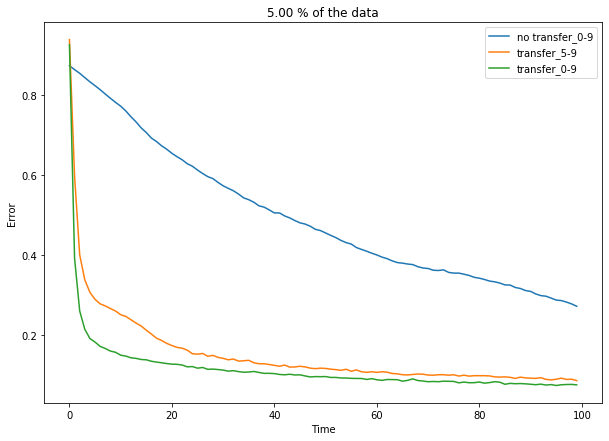

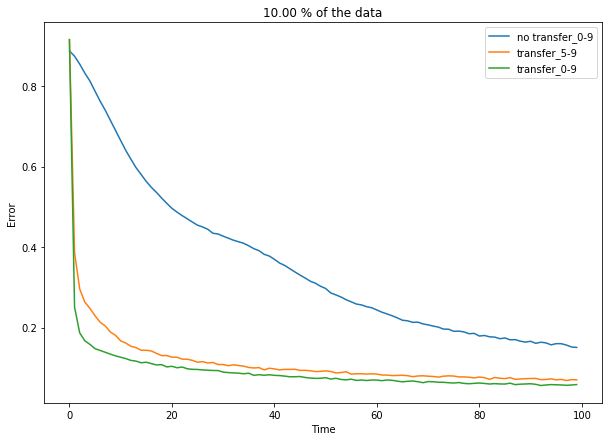

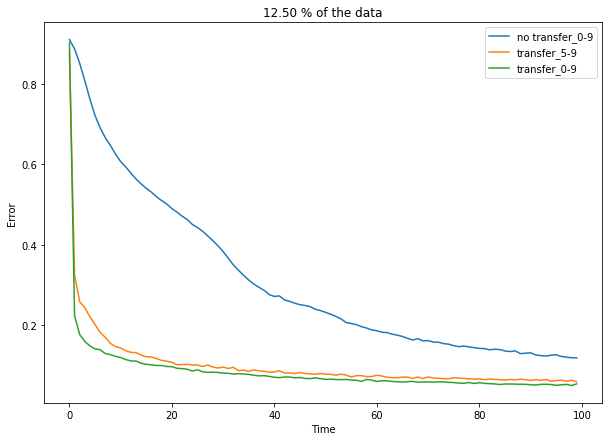

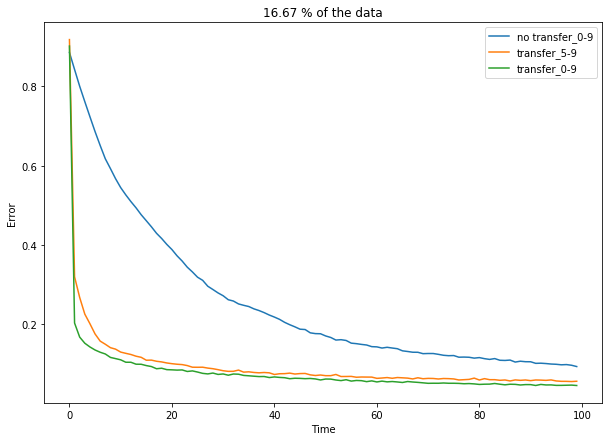

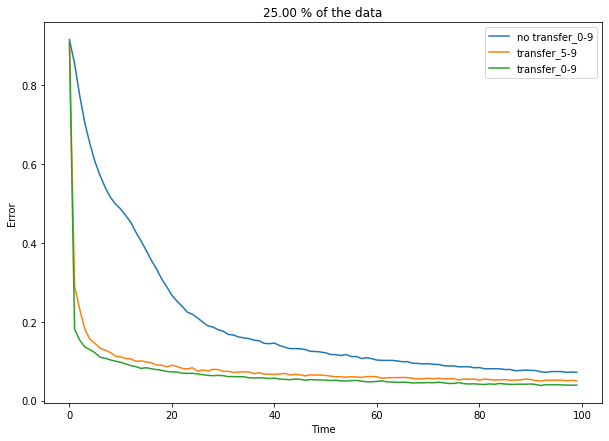

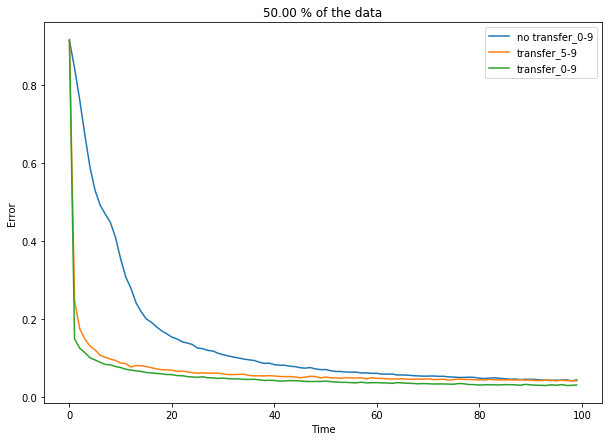

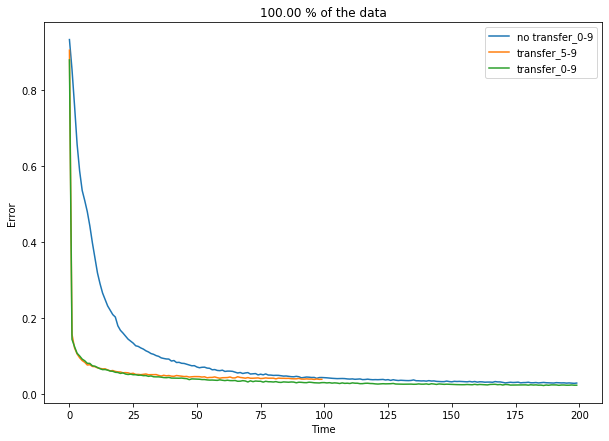

In [50]:
# 然后再绘制它们的误差曲线
for fraction in fractions:
    plt.figure(figsize = (10, 7))
    plt.title('{:.2f} % of the data'.format(100.0 / fraction))
    plt.plot(1 - one_curve[('no transfer_0-9', fraction)], label = 'no transfer_0-9')
    plt.plot(1 - one_curve[('transfer_5-9', fraction)], label = 'transfer_5-9')
    plt.plot(1 - one_curve[('transfer_0-9', fraction)] , label = 'transfer_0-9')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.savefig('{:.2f} % of the data'.format(100.0 / fraction)+'.jpg', dpi=300) 

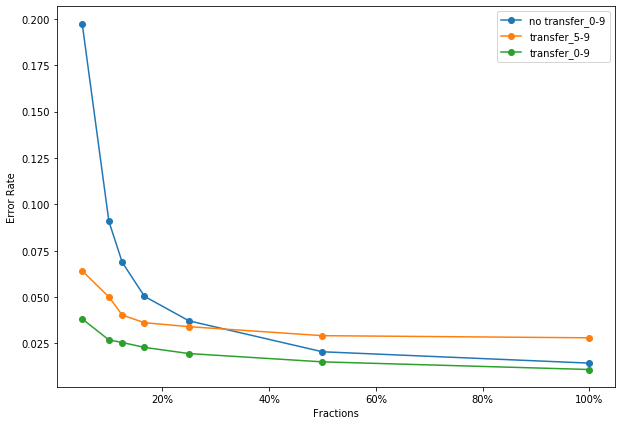

In [49]:
# 绘制测试准确度随着fraction变化的曲线
plt.figure(figsize = (10, 7))
for experiment in ['no transfer_0-9','transfer_5-9','transfer_0-9']:
    testss = []
    for fraction in fractions:
        test = 1 - tests[(experiment, fraction)]
        #test = tests[(experiment, fraction)]
        testss.append(test)
    #x=100/fractions
    x=[1/20, 1/10,1/8, 1/6, 1/4, 1/2, 1]
    plt.plot(x,testss, 'o-', label = experiment)
    plt.legend()
    plt.xlabel('Fractions')
    plt.ylabel('Error Rate')


from matplotlib.ticker import FuncFormatter
def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent))
plt.savefig('fraction---.jpg', dpi=300)

In [43]:
import pickle

 #pickle a variable to a file
file = open('results.pickle', 'wb')
pickle.dump(results, file)
file.close()